In [74]:
import numpy as np

import torch
import torch.nn as nn

import torch.nn.functional as F
from model.model import ResMLP
from pprint import pprint
import json
from torch.cuda.amp import autocast
from tqdm.notebook import tqdm

def read_json(path):
    with open(path, 'r') as stream:
        loaded = json.load(stream)
    return loaded

def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()
            print(m)

def get_monte_carlo_predictions(data_loader,
                                forward_passes,
                                model,
                                n_classes,
                                n_samples):
    """ Function to get the monte-carlo samples and uncertainty estimates
    through multiple forward passes

    Parameters
    ----------
    data_loader : object
        data loader object from the data loader module
    forward_passes : int
        number of monte-carlo samples/forward passes
    model : object
        keras model
    n_classes : int
        number of classes in the dataset
    n_samples : int
        number of samples in the test set
    """

    dropout_predictions = np.empty((0, n_samples, n_classes))
    softmax = nn.Softmax(dim=1)
    for i in tqdm(range(forward_passes)):
        predictions = np.empty((0, n_classes))
        model.eval()
        enable_dropout(model)
        for i, (image, label) in tqdm(enumerate(data_loader)):

            image = image.to('cuda:0')
            with torch.no_grad():
                output = model(image)
                output = softmax(output) # shape (n_samples, n_classes)
            predictions = np.vstack((predictions, output.cpu().numpy()))

        dropout_predictions = np.vstack((dropout_predictions,
                                         predictions[np.newaxis, :, :]))
        # dropout predictions - shape (forward_passes, n_samples, n_classes)
        print(dropout_predictions)
    
    # Calculating mean across multiple MCD forward passes 
    mean = np.mean(dropout_predictions, axis=0) # shape (n_samples, n_classes)

    # Calculating variance across multiple MCD forward passes 
    variance = np.var(dropout_predictions, axis=0) # shape (n_samples, n_classes)

    epsilon = sys.float_info.min
    # Calculating entropy across multiple MCD forward passes 
    entropy = -np.sum(mean*np.log(mean + epsilon), axis=-1) # shape (n_samples,)

    # Calculating mutual information across multiple MCD forward passes 
    mutual_info = entropy - np.mean(np.sum(-dropout_predictions*np.log(dropout_predictions + epsilon),
                                            axis=-1), axis=0) # shape (n_samples,)
    
#     print(mean, variance, entropy, mutual_info)

In [63]:
config_path = './training-results/age-8-add-residual-true-add-ic-true/cross-val/pre-trained/models/ResMLP/0806_105030/config.json'
config = read_json(config_path)

model = ResMLP(**config['arch']['args'])

device = "cpu"
if torch.cuda.is_available():
    device = "cuda:0"
model.to(device)

pprint(sum(p.numel() for p in model.parameters()))
pprint(config['arch']['args'])

checkpoint = torch.load(config_path.replace('config.json', 'model_best.pth'))
state_dict = checkpoint['state_dict']
model.load_state_dict(state_dict)

model.eval()
enable_dropout(model)

825736
{'add_IC': True,
 'add_residual': True,
 'dropout': 0.05,
 'num_blocks': 2,
 'num_classes': 8,
 'num_initial_features': 512,
 'num_residuals_per_block': 1}
Dropout(p=0.05, inplace=False)
Dropout(p=0.05, inplace=False)
Dropout(p=0.05, inplace=False)
Dropout(p=0.05, inplace=False)
Dropout(p=0.05, inplace=False)


In [64]:
from data_loader.data_loaders import AgeDataLoader
data_loader = AgeDataLoader(data_dir='./data/', batch_size=1, shuffle=False, validation_split=0.0, 
                            num_workers=8, dataset='Adience', num_classes=8, training=False, test_cross_val=0,
                            limit_data=None)

In [110]:
predictions = []
for i, (inputs, labels) in tqdm(enumerate(data_loader)):
    inputs, labels = inputs.to(device), labels.to(device)
    with torch.no_grad():
        with autocast():
            outputs = model(inputs.repeat(512, 1))
        outputs = F.softmax(outputs, dim=1)
        predictions.append(outputs.detach().cpu().numpy())

predictions = np.array(predictions)

In [127]:
from scipy.stats import entropy
entropy_all = []

for i, pred in enumerate(predictions):
    value, counts = np.unique(np.argmax(pred, axis=1), return_counts=True)
    entropy_all.append(entropy(counts))

In [155]:
import os
data = np.load(os.path.join('./data', "Adience/data-aligned.npy"),
               allow_pickle=True).item()
data = data[0]

In [162]:
data[8].

dict_keys(['image_path', 'age', 'gender', 'fold', 'embedding'])

1.1764711458052162


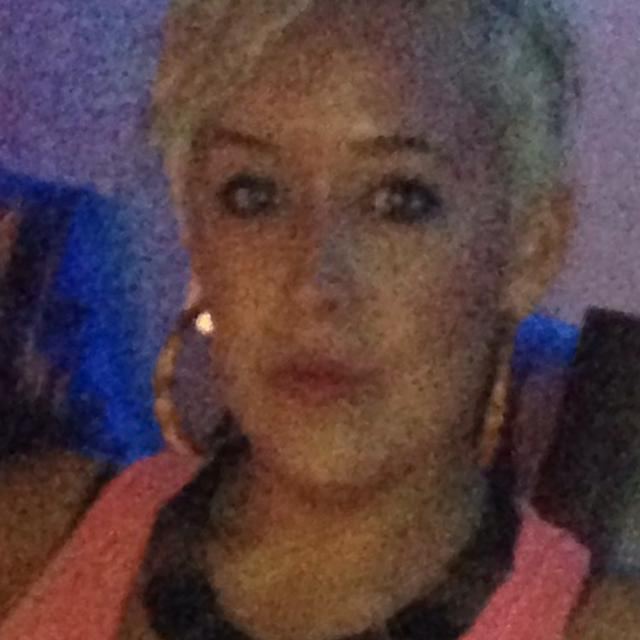

1.1731546607864387


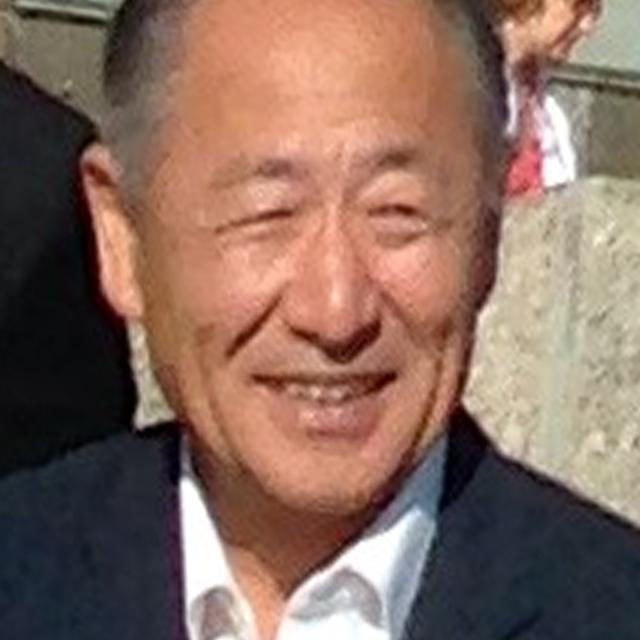

1.1588581710375725


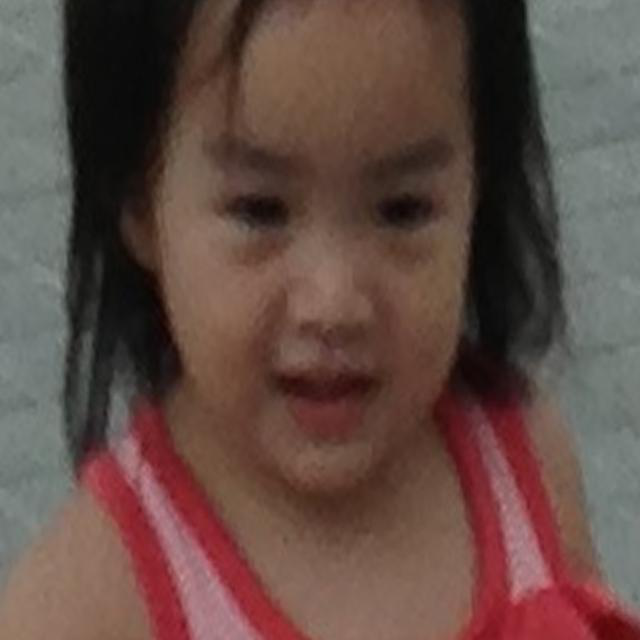

1.1468993218605583


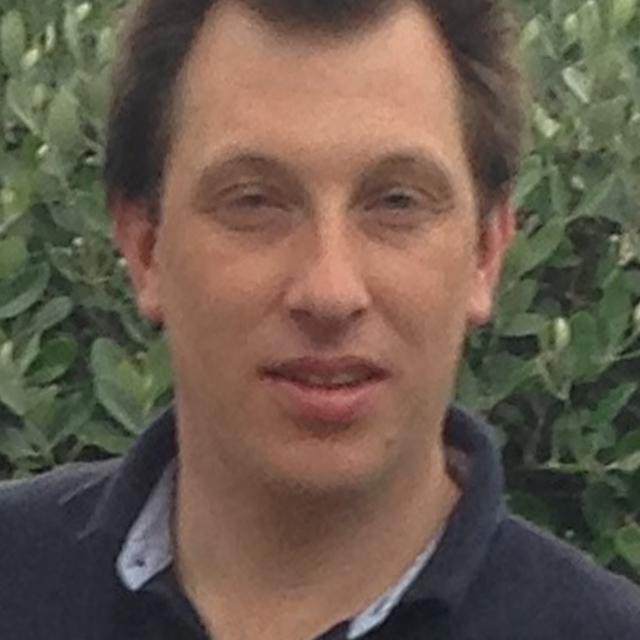

1.132551668660354


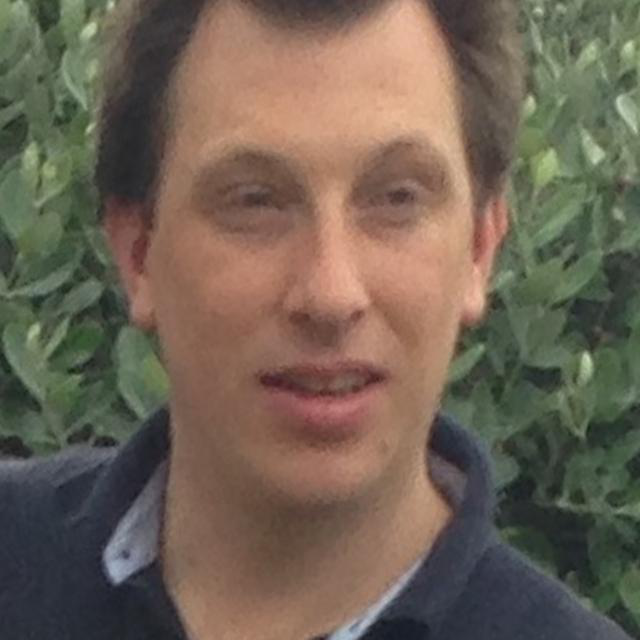

1.12051011478321


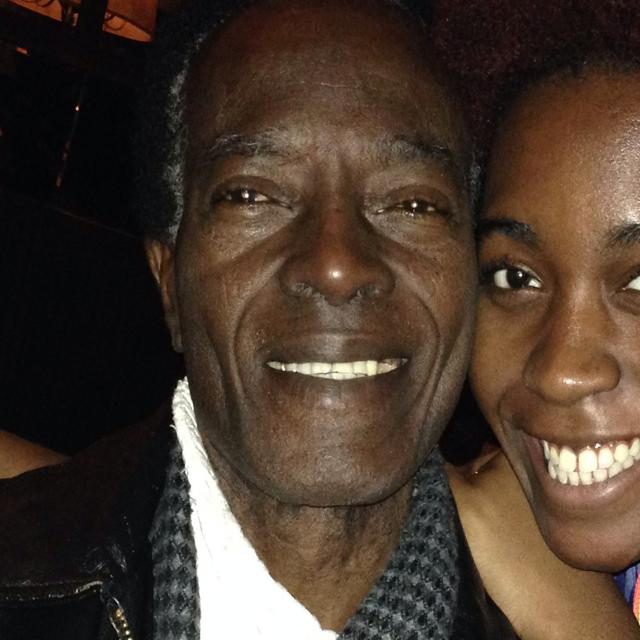

1.0992256206483912


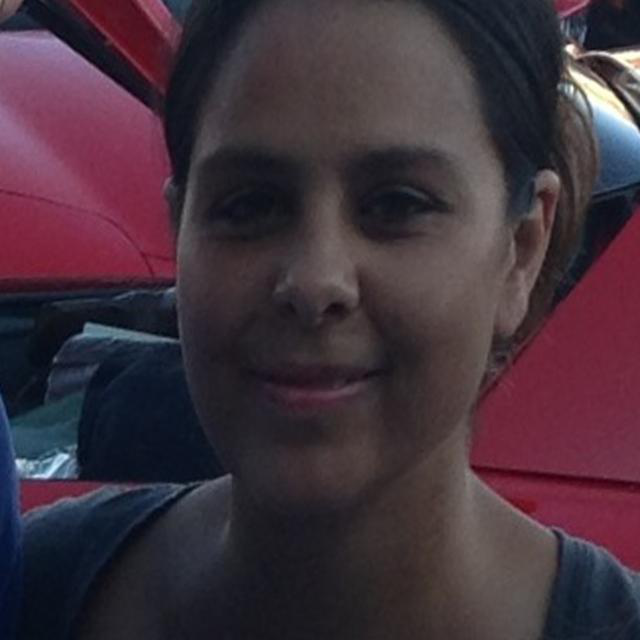

1.0918378649360816


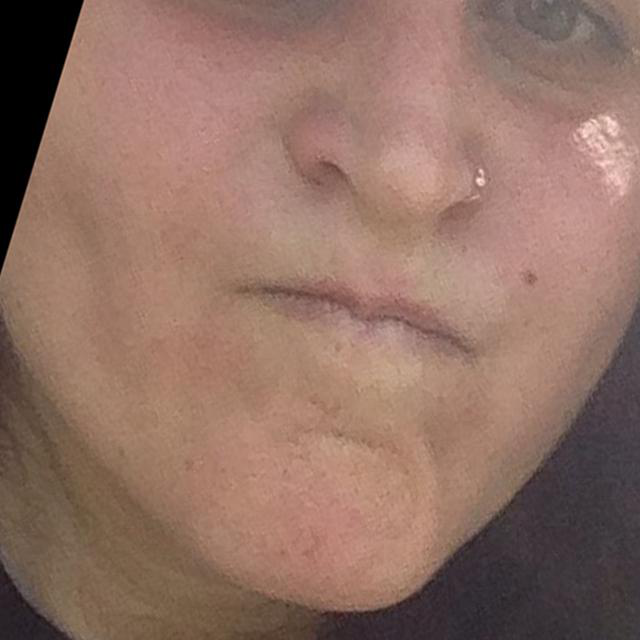

1.0882234163487108


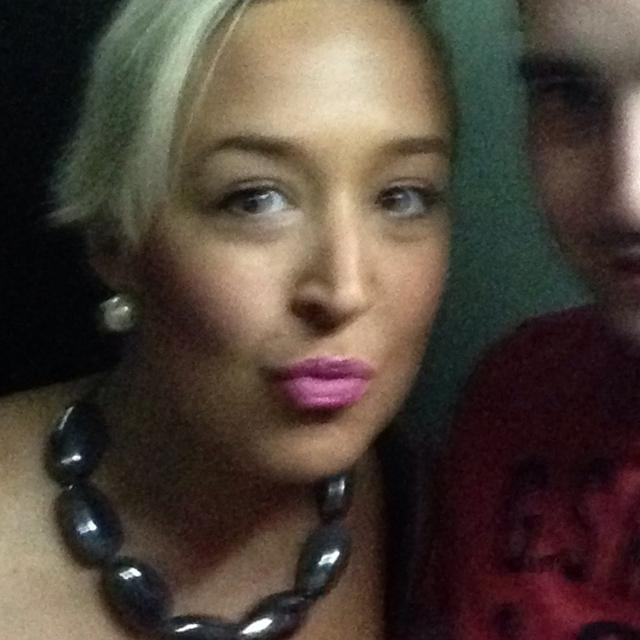

1.0826101118575961


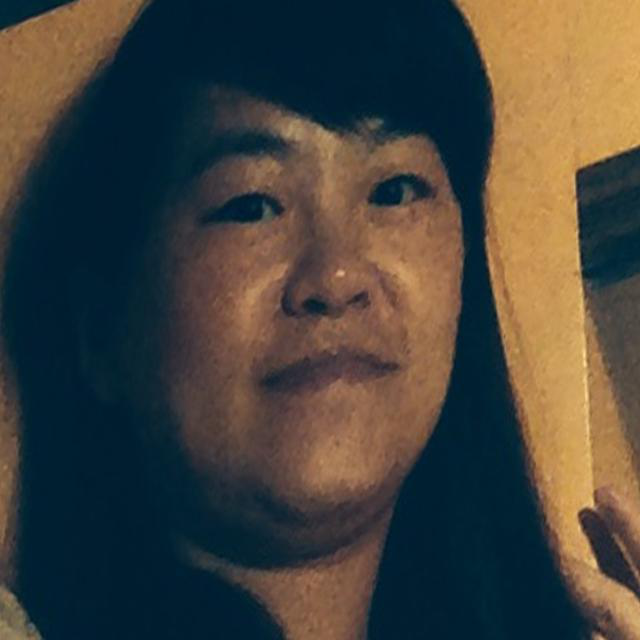

In [170]:
from PIL import Image

for idx in np.array(entropy_all).argsort()[-10:][::-1]:
    image_path = data[idx]['image_path'] + '.RESIZED.jpg'
    print(entropy_all[idx])
    display(Image.open(image_path))

0.0


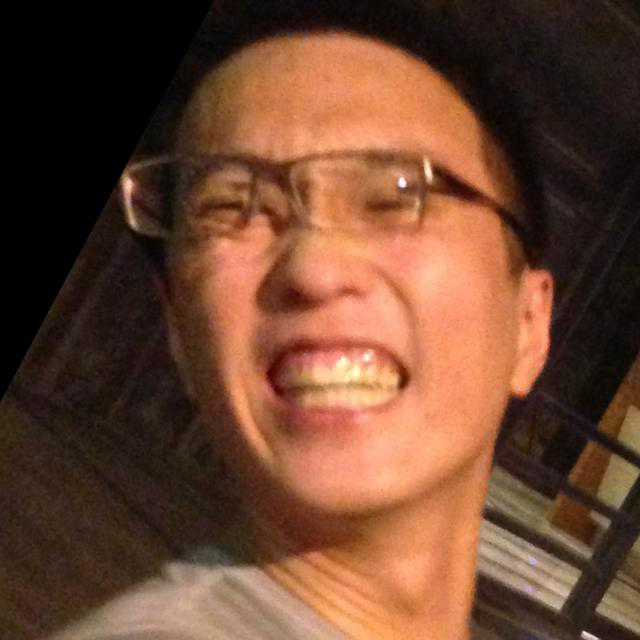

0.0


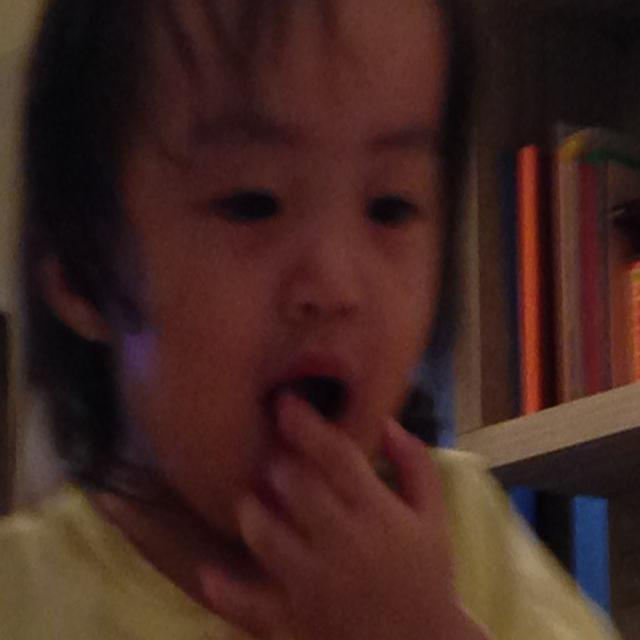

0.0


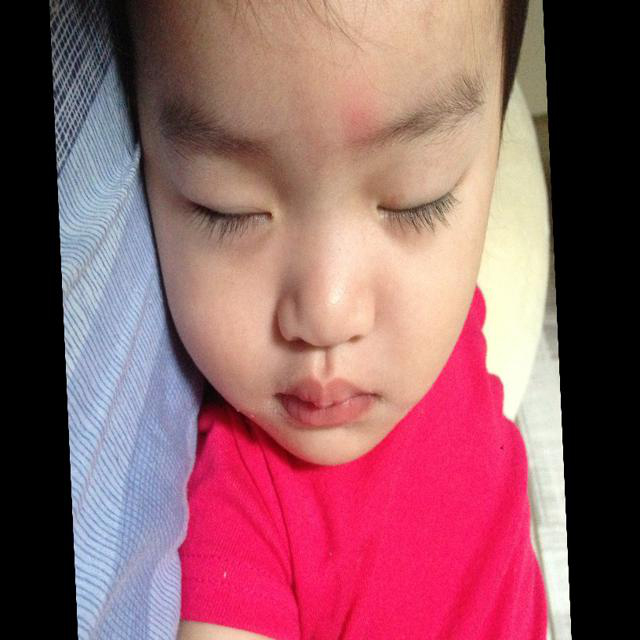

0.0


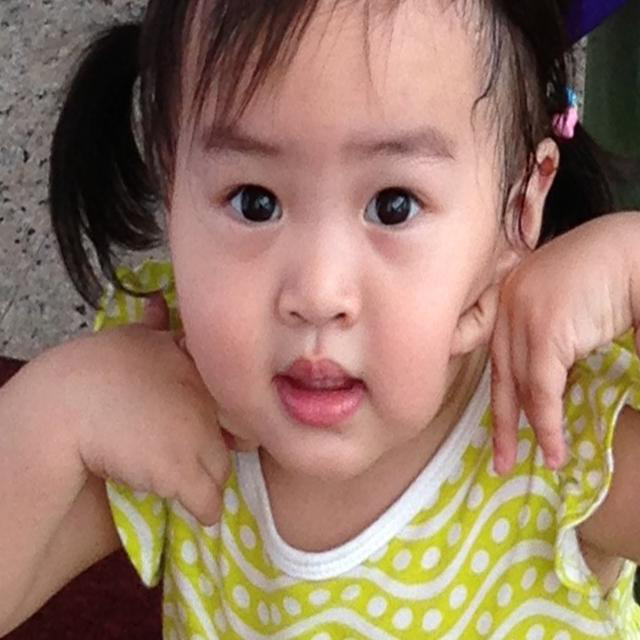

0.0


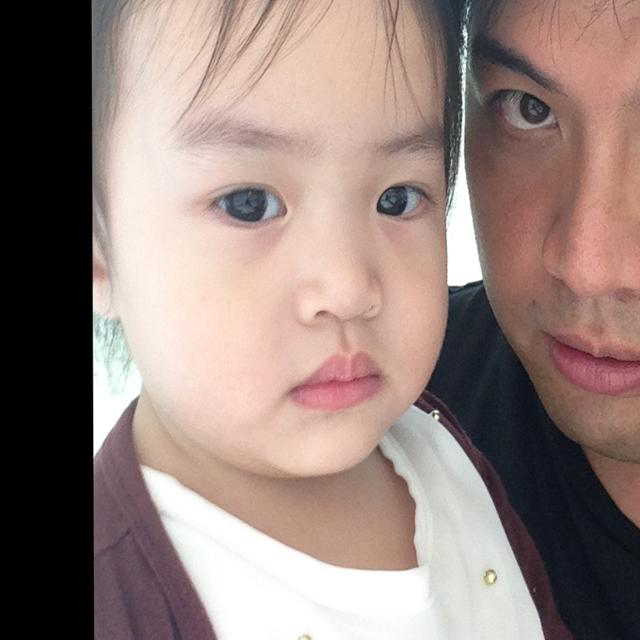

0.0


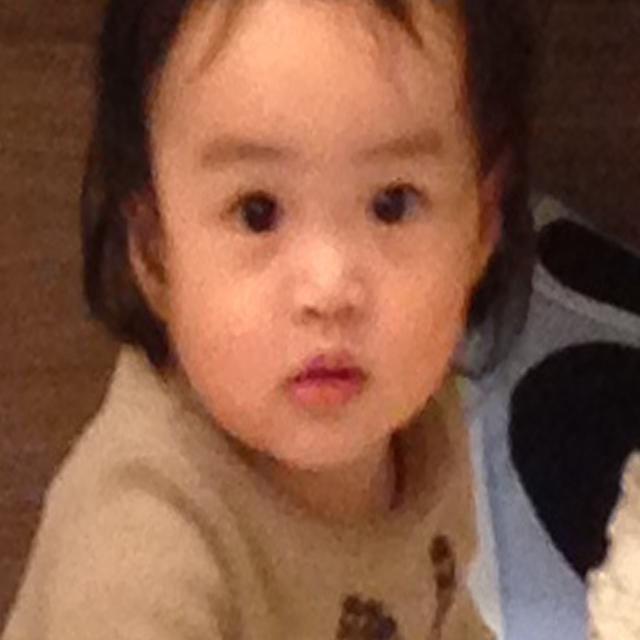

0.0


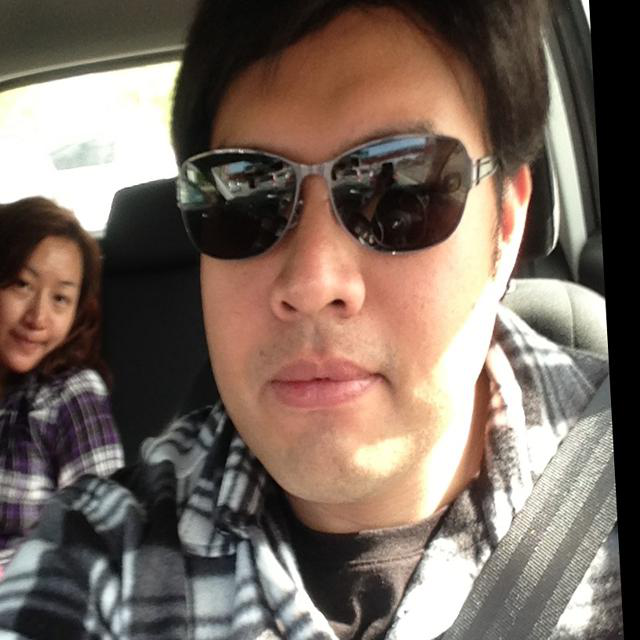

0.0


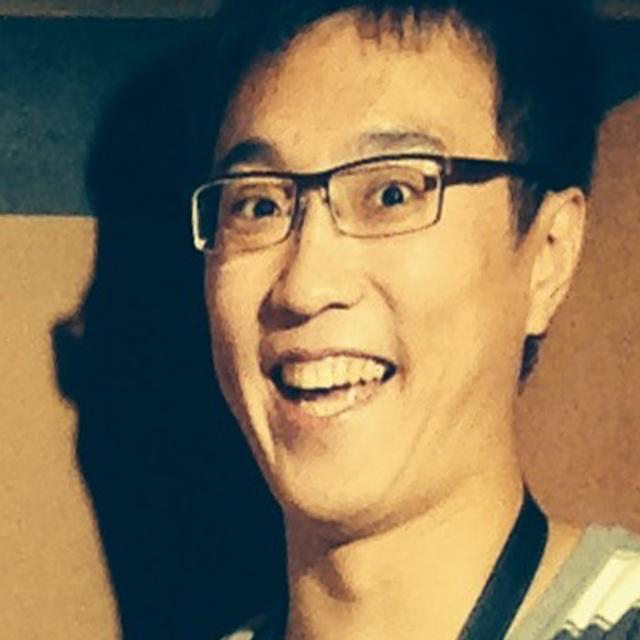

0.0


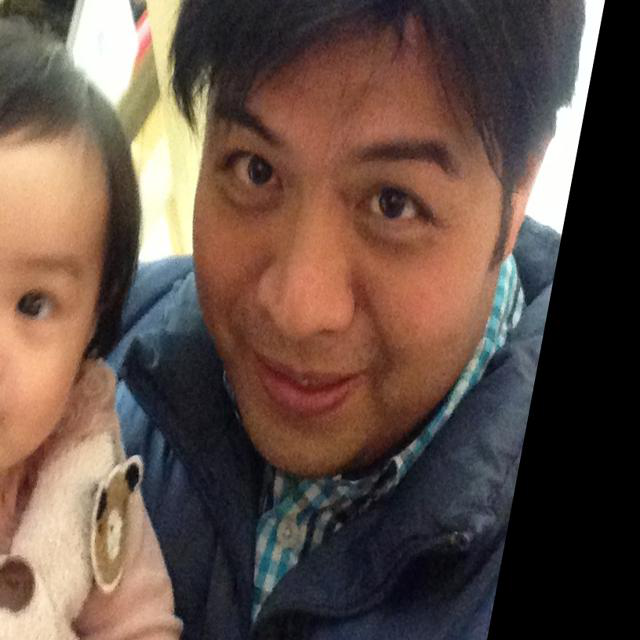

0.0


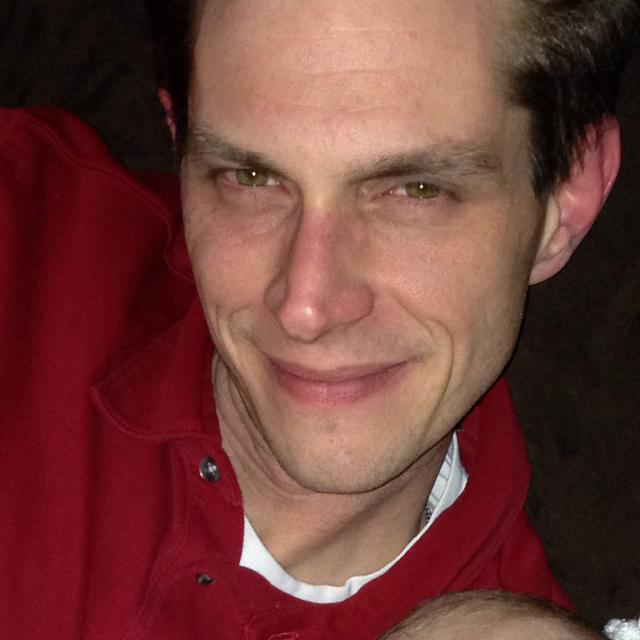

In [172]:
from PIL import Image

for idx in np.array(entropy_all).argsort()[:10][::-1]:
    image_path = data[idx]['image_path'] + '.RESIZED.jpg'
    print(entropy_all[idx])
    display(Image.open(image_path))